This is a python translation of a MATLAB script Rowena sent to me in January, 2023. This notebook creates synthetic displacement time series (same rate, random noise added for nn iterations) and does an inversion with made-up coherence values. 

This notebook: <br>
1. creates displacement data by adding noise to a constant velocity time series (line). This has irregularly-sampled time intervals to show that it works without constant dt.
2. makes coherence values to accompany the data, one value has higher error/standard deviation 
3. creates covariance matrix using noise levels defined above.
4. Inverts a few different ways: using displacements, disp rates, unweighted and weighted.
5. Plots everything.

This notebook was written on 12-19-22. Most recently edited 1-26-23.

***

In [1]:
# import stuff
import numpy as np
import matplotlib.pyplot as plt
import statistics as st
%matplotlib  widget

Create synthetic data.

In [2]:
nd = 10                     # number of dates
nn = 100000                 # number of noise iterations to calc statistics
V = 3                       # velocity 
Sig = 0.5*np.ones((nd,))    # noise (std. dev.s) vector 
print(np.shape(Sig))
Sig[7] = 1                  # bigger noise on the 8th date
print('Sig: '+str(Sig))
Sigm = np.diag(Sig,0)       # same as Cd?
print('Sigm: \n'+str(Sigm))

# Make an array of dates, with first time interval twice as long as the others.
# this shows that the approach doesn't require constant time intervals.
t = np.linspace(0,1,nd+1)
t = np.hstack((t[0],t[2::])); t=t.T
print('t: '+str(t))

# vector of displacement (D) and noise (N) and noisy disp (DN)
D = V*t                                 # true displacements
D2 = np.array([D]*nn).T                 # repeat D for all the columns (nn columns) of a bigger array D2 
N = Sigm.dot(np.random.randn(nd,nn))    # noise for every igram for every iteration 
N2 = np.zeros((nd-1,nn));               # set up second noise array to add extra noise to one igram 

N2[2,:] = 0.8*np.random.randn(nn)       # adds more noise to a single igram. 
N3 = np.zeros(nd-1); N3[2]=0.8          # to add back in the igram-related noise we get from data 
DN = N+D2                               # adding in second layer of noise (igram-related on 3rd igram)

# coherence
coh = np.exp(-(Sig**2)/2) 
print('coh: '+str(coh)) 

(10,)
Sig: [0.5 0.5 0.5 0.5 0.5 0.5 0.5 1.  0.5 0.5]
Sigm: 
[[0.5 0.  0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.5 0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.5 0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.5 0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.5 0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.5 0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.5 0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  1.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.  0.5 0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.  0.  0.5]]
t: [0.  0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]
coh: [0.8824969  0.8824969  0.8824969  0.8824969  0.8824969  0.8824969
 0.8824969  0.60653066 0.8824969  0.8824969 ]


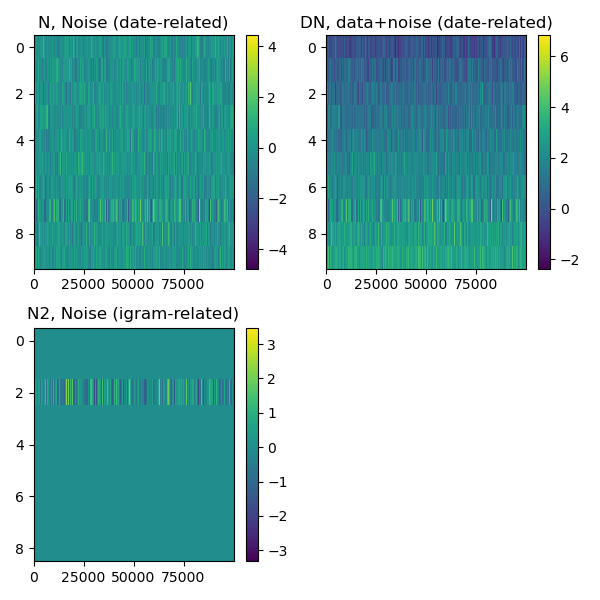

In [3]:
plt.figure(figsize=(6,6),tight_layout='TRUE')
plt.subplot(2,2,1)
plt.imshow(N,aspect='auto',interpolation='nearest')
plt.colorbar(); plt.title('N, Noise (date-related)')
plt.subplot(2,2,2)
plt.imshow(DN,aspect='auto',interpolation='nearest')
plt.colorbar(); plt.title('DN, data+noise (date-related)')
plt.subplot(2,2,3)
plt.imshow(N2,aspect='auto',interpolation='nearest')
plt.colorbar(); plt.title('N2, Noise (igram-related)')
plt.show()

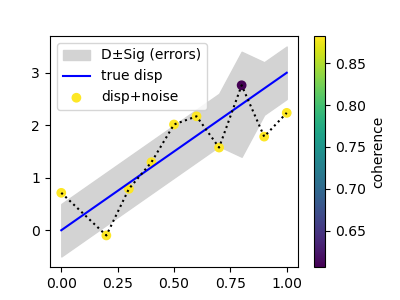

In [4]:
# plot it
plt.figure(figsize=(4,3))
plt.fill_between(t,D+Sig,D-Sig,color='lightgray',label='D\u00B1Sig (errors)')
plt.plot(t,D,color='blue',label='true disp')
plt.plot(t,DN[:,1],'k:',)
plt.scatter(t,DN[:,1],c=coh,label='disp+noise') # only plotting one iteration of noise 
plt.legend(loc='upper left'); plt.colorbar(label='coherence')
plt.show()

In [5]:
# Make design matrix of interferograms 
diags = np.ones((nd-1))
Gint = np.diag(diags,1)-1*np.eye(nd)
Gint = Gint[0:-1,:]
print(Gint)

[[-1.  1.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0. -1.  1.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0. -1.  1.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0. -1.  1.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0. -1.  1.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0. -1.  1.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0. -1.  1.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0. -1.  1.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0. -1.  1.]]


In [6]:
Sigm2 = Sigm*0.0000001
# now diagonals of created covariance matrix are 1's instead of the true value 0.5
# How does this affect the result? 

covi = (Gint.dot(Sigm2**2)).dot(Gint.T)     # interferogram covariance matrix
covi = covi + np.diag(N3,0)

print('covi: \n'+str(covi))                                  
icov = np.linalg.inv(covi)                  # inverse of covariance matrix

# interferograms 
ints = Gint.dot(DN) 

# plt.figure()
# plt.imshow(ints)
# plt.show()

ints = ints+N2                              # noisy interferograms
#print('int: \n'+str(ints))
dt = Gint.dot(t)                            # time intervals 
#covin = np.cov(ints.T)                     # numerically calculate the noise matrix 
covin = np.cov(ints)  
print('diags of covin: \n'+str(np.diag(covin)))
#print('covin: \n'+str(covin))

# print(np.shape(ints))
# plt.figure()
# plt.imshow(ints)
# plt.show()


covi: 
[[ 5.00e-15 -2.50e-15  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00
   0.00e+00  0.00e+00]
 [-2.50e-15  5.00e-15 -2.50e-15  0.00e+00  0.00e+00  0.00e+00  0.00e+00
   0.00e+00  0.00e+00]
 [ 0.00e+00 -2.50e-15  8.00e-01 -2.50e-15  0.00e+00  0.00e+00  0.00e+00
   0.00e+00  0.00e+00]
 [ 0.00e+00  0.00e+00 -2.50e-15  5.00e-15 -2.50e-15  0.00e+00  0.00e+00
   0.00e+00  0.00e+00]
 [ 0.00e+00  0.00e+00  0.00e+00 -2.50e-15  5.00e-15 -2.50e-15  0.00e+00
   0.00e+00  0.00e+00]
 [ 0.00e+00  0.00e+00  0.00e+00  0.00e+00 -2.50e-15  5.00e-15 -2.50e-15
   0.00e+00  0.00e+00]
 [ 0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00 -2.50e-15  1.25e-14
  -1.00e-14  0.00e+00]
 [ 0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00 -1.00e-14
   1.25e-14 -2.50e-15]
 [ 0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00
  -2.50e-15  5.00e-15]]
diags of covin: 
[0.49597938 0.50393482 1.14199494 0.49913326 0.49787866 0.49806195
 1.25319888 1.25139792 0.49891093]


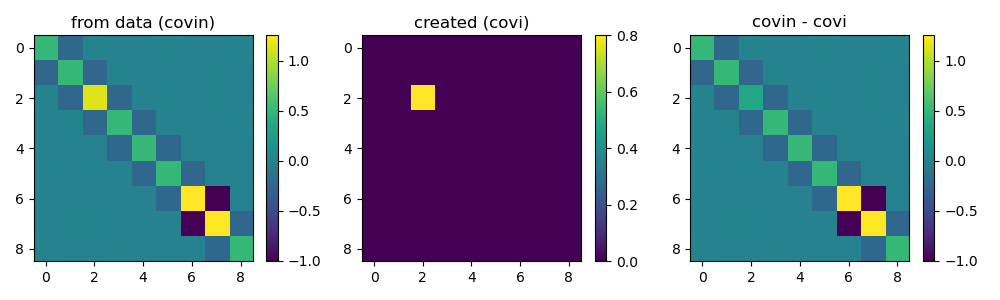

In [7]:
plt.figure(figsize=(10,3),tight_layout='TRUE')
plt.subplot(1,3,1)
plt.imshow(covin,aspect='auto',interpolation='nearest')
plt.title('from data (covin)'); plt.colorbar()
plt.subplot(1,3,2)
plt.imshow(covi,aspect='auto',interpolation='nearest')
plt.title('created (covi)'); plt.colorbar()
plt.subplot(1,3,3)
plt.imshow(covin-covi,aspect='auto',interpolation='nearest')
plt.title('covin - covi'); plt.colorbar()
plt.show()

In [8]:
# initial conversion for disp. vs. time, under assumption that avg=0
to_stack = (np.ones((nd,1))/(nd-1)).T    # avg=0 constraint 
G1 = np.vstack((Gint,to_stack))
#print('G1: \n'+str(G1))
Gg1a = (np.linalg.inv(G1.T.dot(G1))).dot(G1.T)                                                              # no weights
Gg1b = ((np.linalg.inv(G1.T.dot(np.linalg.inv(Sigm**2)).dot(G1))).dot(G1.T)).dot(np.linalg.inv(Sigm**2))    # weights

In [9]:
# inversions using displacements (slope and intercept)
Gd = np.hstack((t.reshape((nd,1)),(np.ones((nd,1)))))
Ggda = np.linalg.inv(Gd.T.dot(Gd)).dot(Gd.T)                                                                # no weights
Ggdb = ((np.linalg.inv(Gd.T.dot(np.linalg.inv(Sigm**2)).dot(Gd))).dot(Gd.T)).dot(np.linalg.inv(Sigm**2))    # weights

In [10]:
# inversion using just dt from ints
Gt = dt; Gt = Gt.reshape((nd-1,1))
Ggta = np.linalg.inv(Gt.T.dot(Gt)).dot(Gt.T)                            # no weights
Ggtb = np.linalg.inv(Gt.T.dot(icov).dot(Gt)).dot(Gt.T).dot(icov)        # weights 

In [11]:
# now do the inversion for displacement, followed by inversion for V
z = np.zeros((1,nn))                # constraint
Da = Gg1a.dot(np.vstack((ints,z)))
Db = Gg1b.dot(np.vstack((ints,z)))
Vda = Ggda.dot(Da)                  # actually 2 parameters, slope and intercept 
Vdb = Ggdb.dot(Db)                 
Vta = Ggta.dot(ints)                # 'stack' inversion
Vtb = Ggtb.dot(ints)                # weighted inversion directly from ints (weighted mean of velocities)

In [12]:
# Calculate std dev on V numerically from this round of inversions
print('numerical std dev of inferred V from: ')
print('inv disp, then V without sigma: '+str(st.stdev(Vda[0,:])))
print('inv disp, then V with sigma: '+str(st.stdev(Vdb[0,:])))
print('inv from ints without sigma (stack): '+str(st.stdev(Vta[0,:])))
print('inv from ints with sigma (stack):'+str(st.stdev(Vtb[0,:]))) 

numerical std dev of inferred V from: 
inv disp, then V without sigma: 1.1264807868981581
inv disp, then V with sigma: 1.110267620069032
inv from ints without sigma (stack): 1.218086920538134
inv from ints with sigma (stack):0.8852623081446349


In [13]:
# now calculate from design of prob 
covVa = Ggda.dot(Ggda.T)            # this is wrong, because it implicitly assumed noise on all dates has variance=1
covVb = Ggdb.dot((Sigm**2)).dot(Ggdb.T)
print('matrix-based std dev of inferred V from:')
print('inv disp, then V without sigma: '+str(np.sqrt(covVa[0,0])))
print('inv disp, then V with sigma: '+str(np.sqrt(covVb[0,0])))
print('inv from ints without sigma (stack): '+str(np.sqrt(Ggta.dot(covi).dot(Ggta.T))[0,0]))
print('inv from ints with sigma (stack):'+str(np.sqrt(Ggtb.dot(covi).dot(Ggtb.T))[0,0])) 

matrix-based std dev of inferred V from:
inv disp, then V without sigma: 1.0403129732205987e+00
inv disp, then V with sigma: 0.536306235381851
inv from ints without sigma (stack): 0.7453559924999366
inv from ints with sigma (stack):8.862870966920817e-08


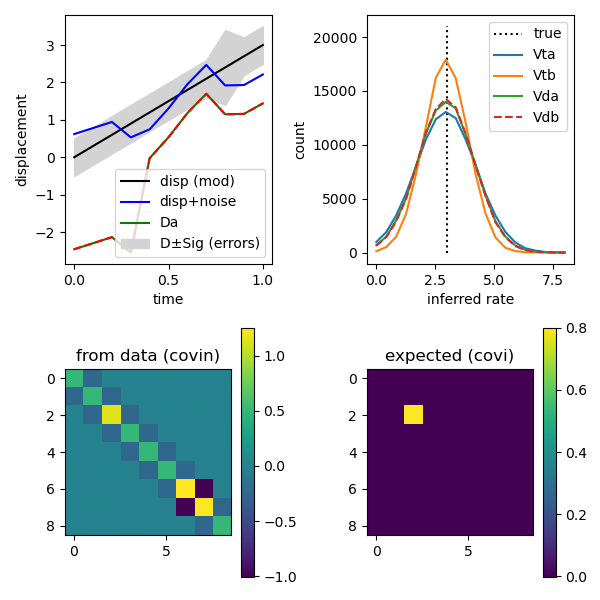

In [14]:
# Now plot stuff
plt.figure(figsize=(6,6),tight_layout='TRUE')
plt.subplot(2,2,1)
plt.plot(t,D,'k-',label='disp (mod)')
plt.plot(t,DN[:,0],'b',label='disp+noise') # only plotting one iteration of noise 
plt.plot(t,Da[:,0],'g',label='Da')
plt.plot(t,Db[:,0],'r--')
plt.fill_between(t,D+Sig,D-Sig,color='lightgray',label='D\u00B1Sig (errors)')
#plt.plot(t,D+Sig,'k:')
#plt.plot(t,D-Sig,'k:')
plt.xlabel('time'); plt.ylabel('displacement')
plt.legend()
plt.subplot(2,2,2)
vs = np.linspace(0,8,20)
hta = np.histogram(Vta, bins=20, range=(0,8))
htb = np.histogram(Vtb, bins=20, range=(0,8))
hda = np.histogram(Vda[0,:], bins=20, range=(0,8))
hdb = np.histogram(Vdb[0,:], bins=20, range=(0,8))
plt.plot([V,V],[0,21000],'k:',label='true')
plt.plot(vs,hta[0],label='Vta')
plt.plot(vs,htb[0],label='Vtb')
plt.plot(vs,hda[0],label='Vda')
plt.plot(vs,hdb[0],'--',label='Vdb')
plt.xlabel('inferred rate'); plt.ylabel('count'); plt.legend()
plt.subplot(2,2,3)
plt.imshow(covin)
plt.title('from data (covin)')
plt.colorbar()
plt.subplot(2,2,4)
plt.imshow(covi)
plt.title('expected (covi)')
plt.colorbar()
plt.show()